In [736]:
import os 
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Import sim functions
from neurodsp.sim import (sim_oscillation, sim_bursty_oscillation, sim_variable_oscillation, sim_damped_oscillation)
from neurodsp.utils import set_random_seed

from neurodsp.sim.combined import sim_combined, sim_peak_oscillation
from neurodsp.sim.aperiodic import sim_powerlaw

# Import function to compute power spectra
from neurodsp.spectral import compute_spectrum

# Import utilities for plotting data
from neurodsp.utils import create_times
from neurodsp.plts.spectral import plot_power_spectra
from neurodsp.plts.time_series import plot_time_series

In [737]:
# Set the random seed, for consistency simulating data
set_random_seed(0)

# Set some general settings, to be used across all simulations
fs = 2000
num_signals = 1000

# Simulation settings
n_seconds = 2
times = create_times(n_seconds, fs)

# Define the components of the combined signal to simulate
n_neurons_range = (800, 1200)  # range for number of neurons
firing_rate_range = (1, 5)     # range for firing rate
t_ker_range = (0.5, 1.5)       # range for t_ker
tau_r_range = (0.0005, 0.005)  # range for tau_r
tau_d_range = (0.010, 0.030)   # range for tau_d
freq_range = (15, 25)          # range for oscillation frequency
amplitude_range = (4, 7)   # range for amplitude_range

# Generate artifact
amplitude = np.random.uniform(amplitude_range[0], amplitude_range[1])
frequency = 130
period = 1 / frequency
num_cycles = int(np.ceil(times[-1] / period))
samples_per_period = int(fs * period)

# Sample values from the specified ranges
n_neurons = np.random.randint(n_neurons_range[0], n_neurons_range[1] + 1)
firing_rate = np.random.uniform(firing_rate_range[0], firing_rate_range[1])
t_ker = np.random.uniform(t_ker_range[0], t_ker_range[1])
tau_r = np.random.uniform(tau_r_range[0], tau_r_range[1])
tau_d = np.random.uniform(tau_d_range[0], tau_d_range[1])
freq = np.random.uniform(freq_range[0], freq_range[1])

# 초기 (0, 4000) 크기의 빈 numpy 배열 생성
set_shape_2d = np.zeros((0, len(times)))
# 초기 (1000, 4000) 크기의 빈 numpy 배열 생성
set_shape_2d_2 = np.zeros((num_signals, len(times)))
# 초기 (4000, ) 크기의 빈 numpy 배열 생성
set_shape_1d = np.zeros(len(times))

# -------- < original signal data > ------------------------------------------------

data_signal = set_shape_2d.copy()

# -------- < artifact data - type > ------------------------------------------------

data_sine = set_shape_2d.copy()
data_non_sine_v1 = set_shape_2d.copy()
data_non_sine_v2 = set_shape_2d.copy()

# -------- < artifact data - varying, burst, frequency > ------------------------------------------------

data_varying = set_shape_2d_2.copy()
data_burst_short = set_shape_2d.copy()
data_burst_more = set_shape_2d.copy()
data_freq = set_shape_2d.copy()

# -------- < synthesized data > ------------------------------------------------

data_with_non_sine_v2_varying = set_shape_2d.copy()
data_with_non_sine_v2_freq = set_shape_2d.copy()


In [738]:
# ---------------------- << 생성 - data_signal >> ----------------------------------------------------------------------------------------------------------
for idx in range(num_signals):
   components = {
      'sim_synaptic_current': {
      'n_neurons': n_neurons,
      'firing_rate': firing_rate,
      't_ker': t_ker,
      'tau_r': tau_r,
      'tau_d': tau_d
      },
      'sim_oscillation': {
      'freq': freq
      }
   }
   # Simulate an oscillation over an aperiodic component
   signal = sim_combined(n_seconds, fs, components)

   data_signal = np.vstack((data_signal, signal))
   
print("data_sine shape:", data_signal.shape) # (1000, 4000)

data_sine shape: (1000, 4000)


Text(0.5, 1.0, 'data_signal')

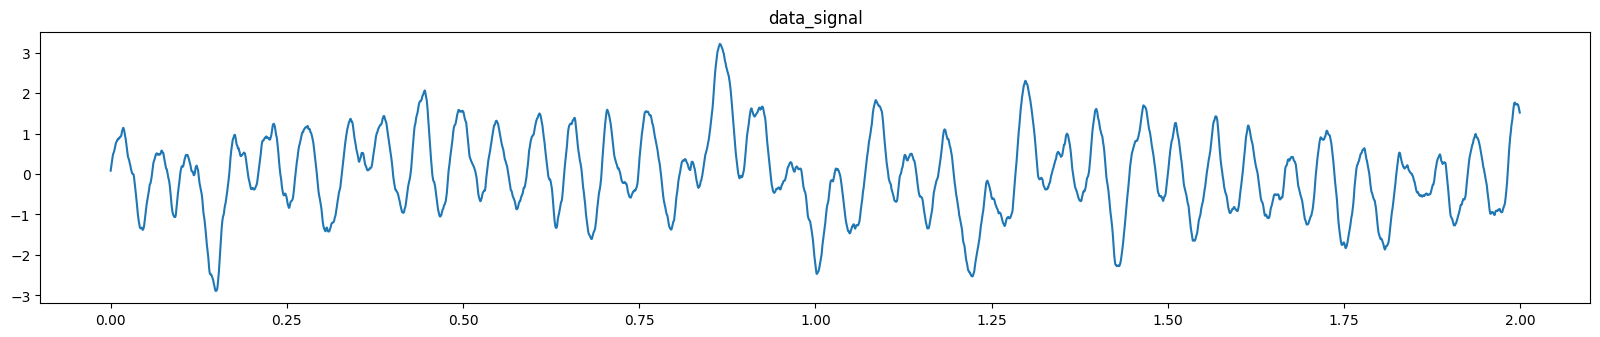

In [739]:
# 확대할 구간 설정
plt.figure(figsize=(20, 12))

plt.subplot(3,1,1)
plt.plot(times, data_signal[1, :])
plt.title('data_signal')

data_sine shape: (1000, 4000)


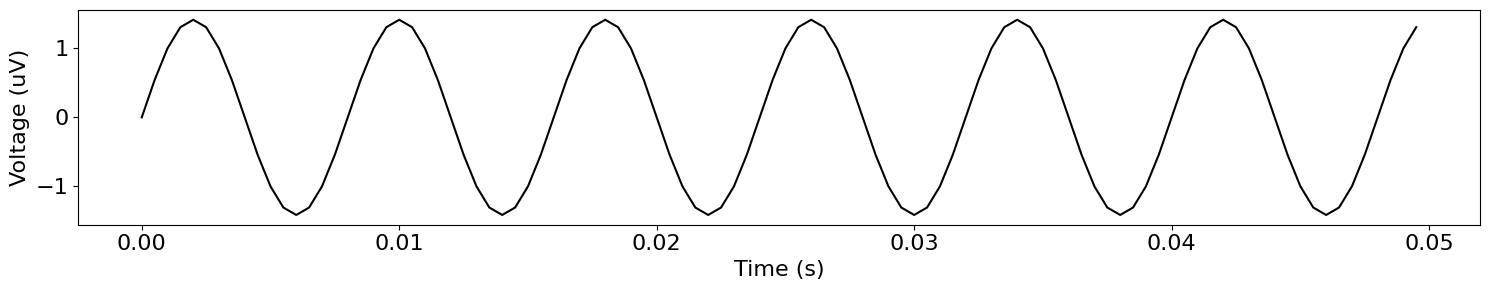

In [740]:
# ------------------------------------<< sinusoidal oscillation >>------------------------------------------------------------------------------------------
# Simulate a sinusoidal oscillation
for idx in range(num_signals):
    # Generate a 130 Hz sine wave
    osc_sine = sim_oscillation(n_seconds, fs, frequency, cycle='sine')

    data_sine = np.vstack((data_sine, osc_sine))
    
# Plot the simulated data, in the time domain
plot_time_series(times[0:100], data_sine[1, 0:100])
print("data_sine shape:", data_sine.shape) # (1000, 4000)

data_non_sine_v1 shape: (1000, 4000)


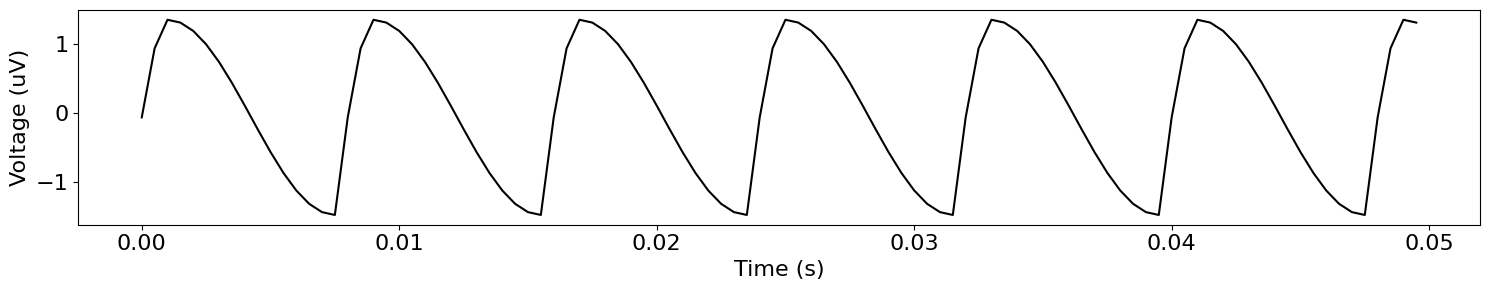

In [741]:
# ------------------------------------<< non-sinusoidal oscillation >>------------------------------------------------------------------------------------------
# Define settings
rdsym = 0.2

# Simulate a non-sinusoidal oscillation
# osc_shape = sim_oscillation(n_seconds, fs, frequency, cycle='asine', rdsym=rdsym)

for idx in range(num_signals):
    # Generate a 130 Hz sine wave
    osc_shape = sim_oscillation(n_seconds, fs, frequency, cycle='asine', rdsym=rdsym)

    data_non_sine_v1 = np.vstack((data_non_sine_v1, osc_shape))
    
# Plot the simulated data, in the time domain
plot_time_series(times[0:100], data_non_sine_v1[1, 0:100])
print("data_non_sine_v1 shape:", data_non_sine_v1.shape) # (1000, 4000)

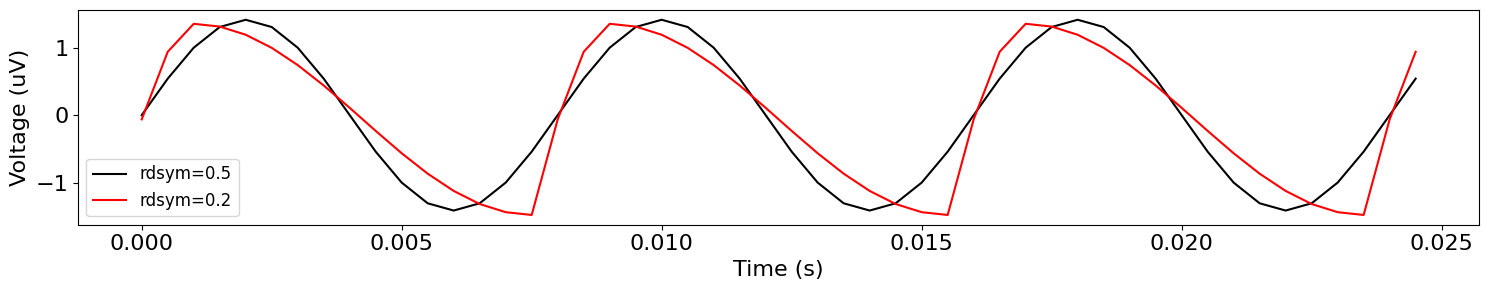

In [742]:
# Plot the simulated data, in the time domain
plot_time_series(times[0:50], [data_sine[1, 0:50], data_non_sine_v1[1, 0:50]], labels=['rdsym='+str(.5), 'rdsym='+str(rdsym)])

In [743]:
# negative 영역 확장
neg_part = set_shape_1d.copy()
neg_parts = set_shape_2d.copy()

# positive 영역 유지
pos_part = set_shape_1d.copy()
pos_parts = set_shape_2d.copy()
neg_parts_hang = set_shape_2d_2.copy()

# negative/positive 영역 분리
for idx in range(num_signals):
    neg_part = np.where(data_non_sine_v1[idx, :] < 0, data_non_sine_v1[idx, :], 0)
    neg_parts = np.vstack((neg_parts, neg_part))

neg_parts = neg_parts * 1.5

for idx in range(num_signals):
    pos_part = np.where(data_non_sine_v1[idx, :] > 0, data_non_sine_v1[idx, :], 0)
    pos_parts = np.vstack((pos_parts, pos_part))

pos_parts shape: (1000, 4000)
neg_parts shape: (1000, 4000)
neg_parts: [ 0.          0.         -0.35013143 -0.84763772 -1.30134147 -1.68487507
 -1.97594893 -2.15764691]
neg_parts_varying: [0. 0. 0. 0. 0. 0. 0. 0.]


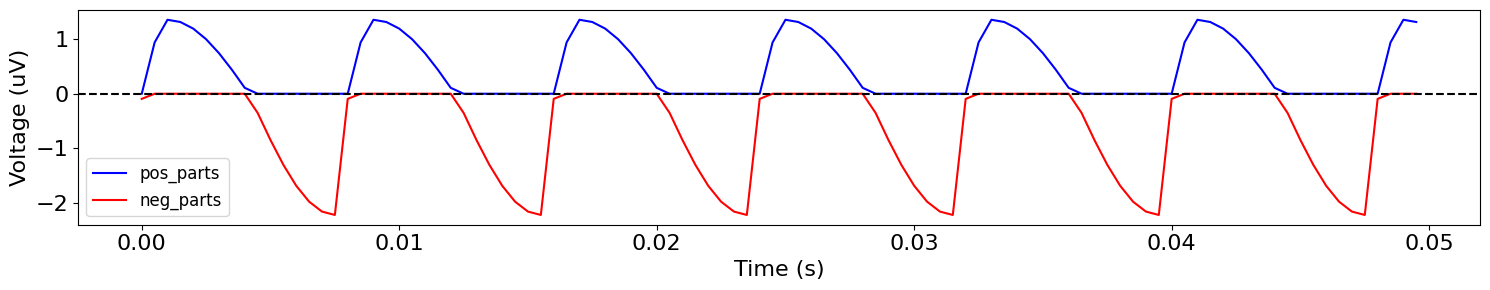

In [744]:
plot_time_series(times[0:100], [pos_parts[1, 0:100], neg_parts[1, 0:100]], 
                 labels=['pos_parts', 'neg_parts'], colors=['b', 'r'])
plt.axhline(y=0, color='k', linestyle='--')

print('pos_parts shape:', pos_parts.shape)
print('neg_parts shape:', neg_parts.shape)

print('neg_parts:', neg_parts[1, 7:15])
print('neg_parts_varying:', neg_parts_hang[1, 7:15])

data_non_sine_v2 shape: (1000, 4000)


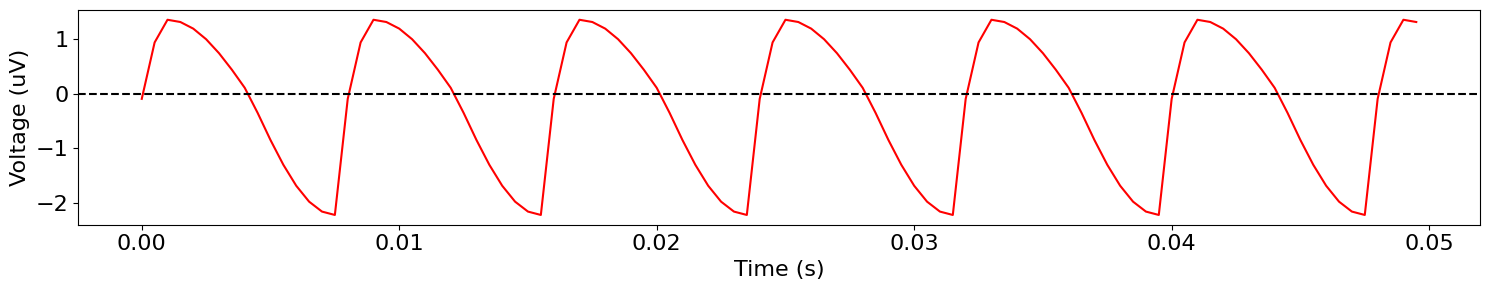

In [745]:
# data_non_sine_v2 생성
data_non_sine_v2 = pos_parts + neg_parts

plot_time_series(times[0:100], data_non_sine_v2[1, 0:100], colors = 'r')
plt.axhline(y=0, color='k', linestyle='--')

print('data_non_sine_v2 shape:', data_non_sine_v2.shape)

In [746]:
# Varying 추가
random_amplitudes = np.random.uniform(0.75, 1.25, num_signals)

for idx in range(num_signals):
    for i in range(num_cycles):
        start_idx = i * samples_per_period
        end_idx = min((i + 1) * samples_per_period, len(times))

        if start_idx >= len(times):
            break

        each_period = set_shape_1d.copy()
        each_period[start_idx:end_idx] = random_amplitudes[idx] * data_non_sine_v2[idx, start_idx:end_idx]
        data_varying[idx, start_idx:end_idx] += each_period[start_idx:end_idx]
    
print(data_varying.shape)

(1000, 4000)


In [747]:
data_with_non_sine_neg_varying = data_signal + data_varying

data_varying shape: (1000, 4000)


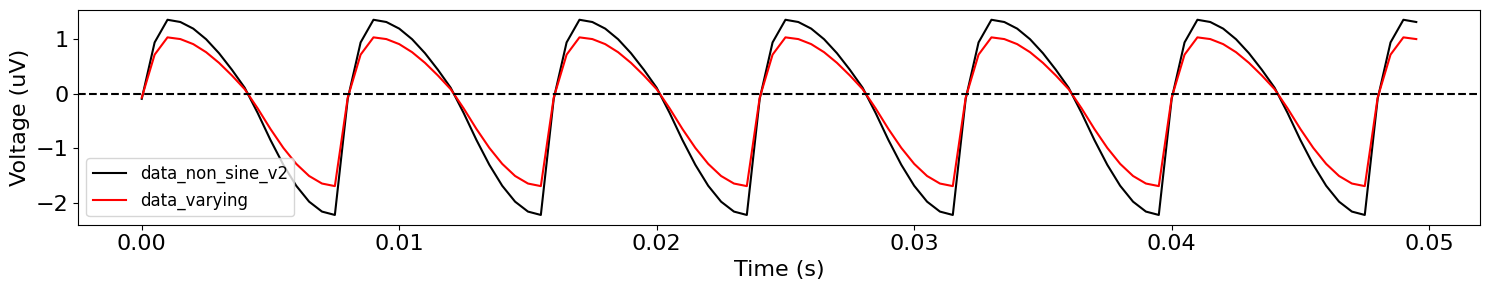

In [ ]:
plot_time_series(times[0:300], [data_non_sine_v2[1, 0:300], data_varying[1, 0:300]], 
                 labels=['data_non_sine_v2', 'data_varying'], colors=['k', 'r'])
plt.axhline(y=0, color='k', linestyle='--')

print('data_varying shape:', data_varying.shape)

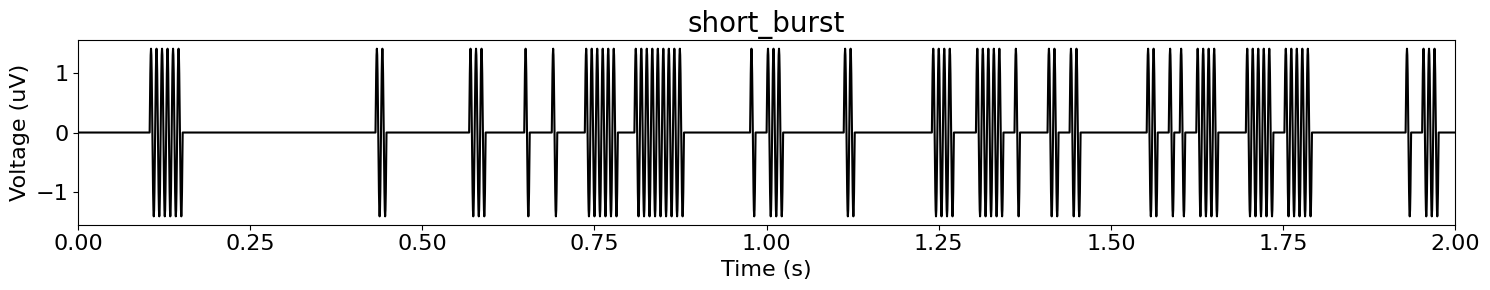

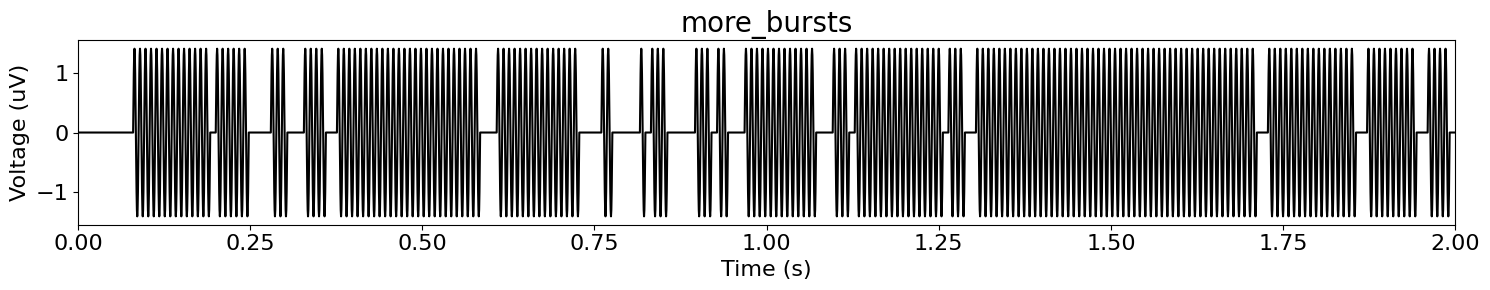

In [749]:
# Burst 소개
# enter_burst: 진동이 burst 상태로 들어가는 확률
# inter_burst: 진동이 burst 상태에서 나오는 확률

# Simulate a bursty oscillation, with a higher probability to leave bursts
short_burst = sim_bursty_oscillation(n_seconds, fs, frequency, enter_burst=0.1, leave_burst=0.4)

# Simulate a bursty oscillation, with a higher probability of entering bursts
more_bursts = sim_bursty_oscillation(n_seconds, fs, frequency, enter_burst=0.4, leave_burst=0.1)

# Plot the simulated burst signals
# plot_time_series(times, [short_burst, more_bursts], xlim=[0, n_seconds], labels=['short_burst', 'more_bursts'], colors=['m', 'y'])
plot_time_series(times, short_burst, xlim=[0, n_seconds], title='short_burst')
plot_time_series(times, more_bursts, xlim=[0, n_seconds], title='more_bursts')

(1000, 4000)
(1000, 4000)


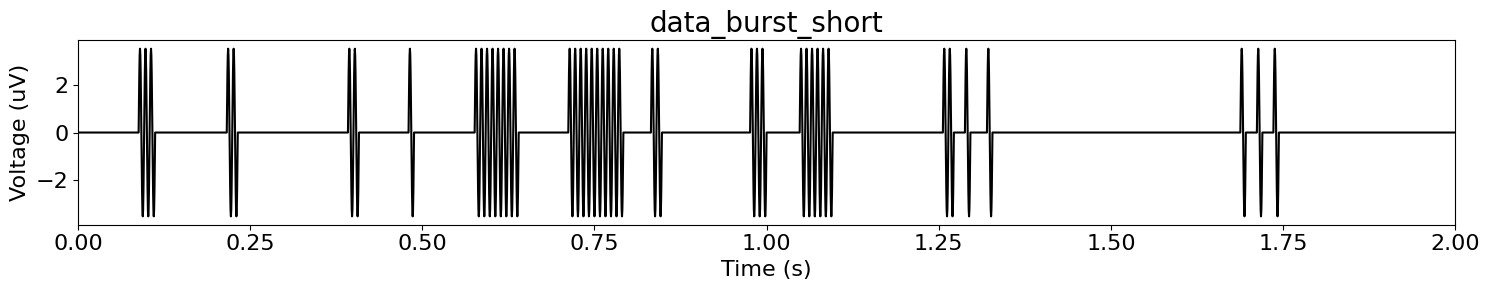

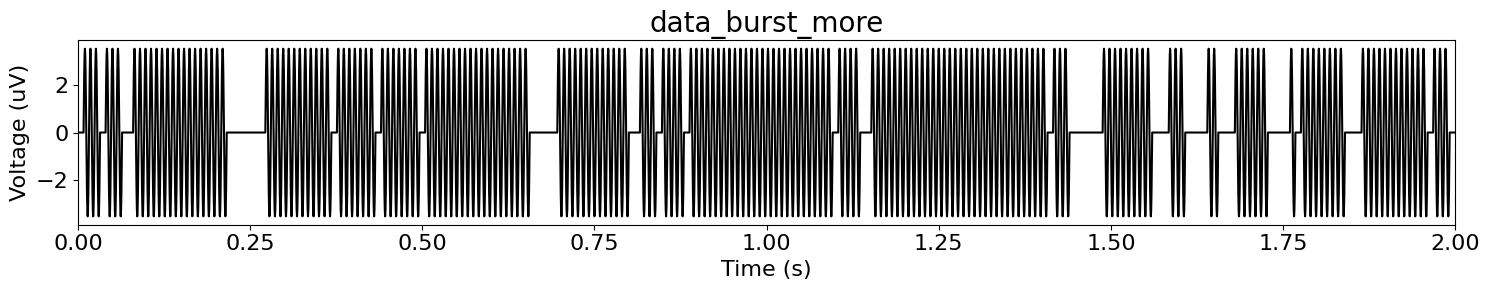

In [750]:
# Burst mask 생성
burst_amplitude = 2.5 # burst 신호의 진폭은 몇 uV에서 수 십 uV까지 다양

data_burst_short = set_shape_2d_2.copy()
data_burst_more = set_shape_2d_2.copy()

# Short burst 생성
for idx in range(num_signals):
    short_burst = burst_amplitude * sim_bursty_oscillation(n_seconds, fs, frequency, enter_burst=0.1, leave_burst=0.4)
    data_burst_short[idx] = short_burst

# More bursts 생성
for idx in range(num_signals):
    more_bursts = burst_amplitude * sim_bursty_oscillation(n_seconds, fs, frequency, enter_burst=0.4, leave_burst=0.1)
    data_burst_more[idx] = more_bursts

plot_time_series(times, data_burst_short[1, :], xlim=[0, n_seconds], title='data_burst_short')
plot_time_series(times, data_burst_more[1, :], xlim=[0, n_seconds], title='data_burst_more')

print(data_burst_short.shape)
print(data_burst_more.shape)

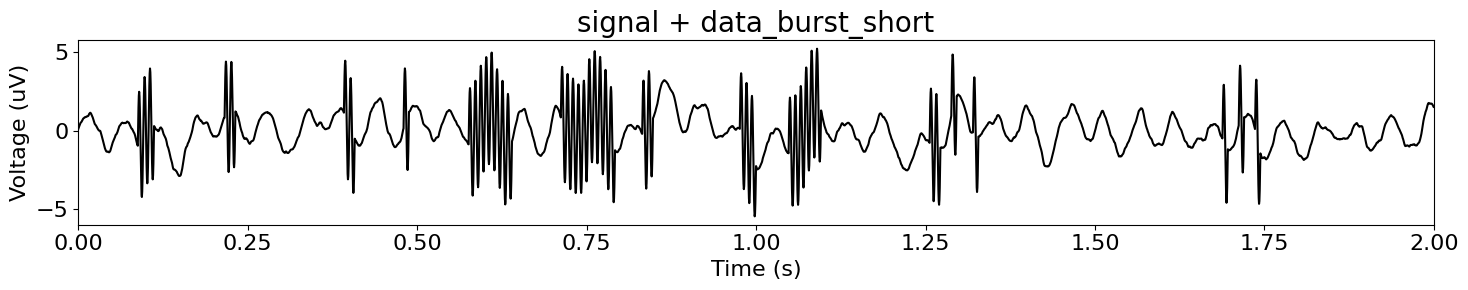

In [751]:
# short burst mask 씌워보기
test = data_signal + data_burst_short
plot_time_series(times, test[1, :], xlim=[0, n_seconds], title='signal + data_burst_short')

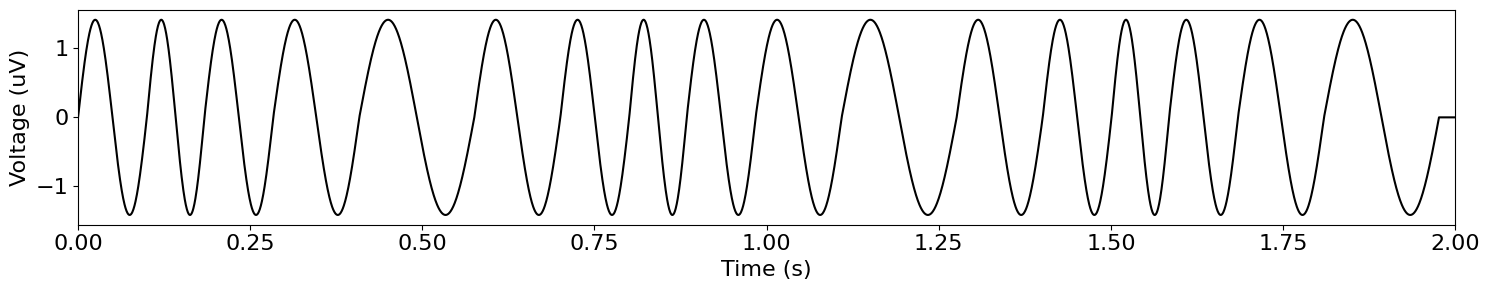

In [752]:
# freq. 소개
# Define variable frequencies
freqs = np.tile([10, 12, 10, 8, 6, 8], 5)
# freqs = np.tile([120, 125, 130, 135, 140], 5)
# freqs = np.tile([300, 500, 130, 700, 100], 100)

# Simulate variable oscillatory signal
variable = sim_variable_oscillation(n_seconds, fs, freqs)

# Plot the simulated variable signal
plot_time_series(times, variable, xlim=[0, n_seconds])

In [753]:
# freq. 생성
data_freq = set_shape_2d.copy()

# Define variable frequencies
freqs_zip = [130, 150, 300]
# freqs_zip = [110, 115, 120, 125, 130, 135, 140, 145, 150]
# freqs_zip = [120, 125, 130, 135, 140]

freqs = np.tile(freqs_zip, round(frequency * n_seconds / len(freqs_zip)))
np.random.shuffle(freqs)

# Simulate a non-sinusoidal oscillation
for idx in range(num_signals):
    # Simulate variable oscillatory signal
    variable = sim_variable_oscillation(n_seconds, fs, freqs, cycle='asine', rdsym=rdsym)
    data_freq = np.vstack((data_freq, variable))

# negative 영역 확장
neg_part_2 = set_shape_1d.copy()
neg_parts_2 = set_shape_2d.copy()
# positive 영역 유지
pos_part_2 = set_shape_1d.copy()
pos_parts_2 = set_shape_2d.copy()
neg_parts_hang = set_shape_2d_2.copy()

# negative/positive 영역 분리
for idx in range(num_signals):
    neg_part_2 = np.where(data_freq[idx, :] < 0, data_freq[idx, :], 0)
    neg_parts_2 = np.vstack((neg_parts_2, neg_part_2))
neg_parts_2 = neg_parts_2 * 1.5

for idx in range(num_signals):
    pos_part_2 = np.where(data_freq[idx, :] > 0, data_freq[idx, :], 0)
    pos_parts_2 = np.vstack((pos_parts_2, pos_part_2))
    
data_freq = pos_parts_2 + neg_parts_2

# Plot the simulated data, in the time domain
plot_time_series(times[0:500], data_freq[1, 0:500])
plot_time_series(times[0:500], [data_non_sine_v2[1, 0:500], data_freq[1, 0:500]], colors = ['k', 'r'])

print("data_freq shape:", data_freq.shape) # (1000, 4000)

In [ ]:
data_with_non_sine_v2_freq = data_signal + data_freq

In [ ]:
# # -------- < 저장 > ------------------------------------------------

# fpath = "../data/synthetic_data/"

# # -------- < original signal data > ------------------------------------------------

# np.save(fpath + "clean_data" + ".npy", data_signal)

# # # -------- < artifact data - type > ------------------------------------------------

# # np.save(fpath + "data_sine" + ".npy", data_sine)
# # np.save(fpath + "data_non_sine_v1" + ".npy", data_non_sine_v1)
# # np.save(fpath + "data_non_sine_v2" + ".npy", data_non_sine_v2)

# # # -------- < artifact data - varying, burst, frequency > ------------------------------------------------

# # np.save(fpath + "data_varying" + ".npy", data_varying)
# np.save(fpath + "data_burst_short" + ".npy", data_burst_short)
# np.save(fpath + "data_burst_more" + ".npy", data_burst_more)
# # np.save(fpath + "data_freq" + ".npy", data_freq)

# # -------- < synthesized data > ------------------------------------------------

# np.save(fpath + "data_with_non_sine_v2_varying" + ".npy", data_with_non_sine_v2_varying)
# np.save(fpath + "data_with_non_sine_v2_freq" + ".npy", data_with_non_sine_v2_freq)
